# **<ul>Great Learning - Neural Nets - Loan Default Predictions</ul>** #

### **Notebook set-up** 

### **Imports**

In [52]:
# Standard library imports
from pathlib import Path


import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import t
from scipy.stats import boxcox, yeojohnson, shapiro
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import (
    KBinsDiscretizer,
    PowerTransformer,
    QuantileTransformer,
    MinMaxScaler,
    StandardScaler,
    OrdinalEncoder,
    OneHotEncoder,
    LabelEncoder,
    PolynomialFeatures
)
import platform
import sys
import platform
import sys

# How to tell python version
#print (sys.version_info)
#print (platform.python_version())

# How to pip install from Terminal window:
# python -m pip install seaborn

# Put this at the top of your notebook
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 1000)  # Set a large number
pd.set_option('display.max_colwidth', None)

# Set random seed for reproducibility
np.random.seed(315)

### **Data Loading**

In [53]:
# Set file paths based on environment
full_dataset_path = 'Dataset - GenAI-Powered Food Delivery Sentiment Analysis.csv'

# Load the training and testing datasets
df_full_dataset = pd.read_csv(full_dataset_path)

data_set_name = 'Food Delivery Sentiment Analysis'

feature_label = 'Category'
target_label = 'Category'

#####  **Utility Function Definitions** #####

In [54]:
def DisplaySampleDataInTable(df_target, table_title=None, max_cell_length=30, fig_width=18):

    if df_target.empty:
        print(f"No data to display{': ' + table_title if table_title else ''}")
        return

    n_rows, n_cols = df_target.shape

    fig_height = (n_rows + 1) * 0.35
    if table_title:
        fig_height += 0.4

    if fig_width == None:
        fig_width = n_cols * 1.5

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Format floats and truncate long text
    cell_text = []
    for row in df_target.values:
        new_row = []
        for val in row:
            if isinstance(val, (float, int)) and not isinstance(val, bool):
                new_row.append(f"{val:.2f}")
            else:
                s = str(val)
                if len(s) > max_cell_length:
                    s = s[:max_cell_length - 3] + '...'
                new_row.append(s)
        cell_text.append(new_row)

    table = ax.table(
        cellText=cell_text,
        colLabels=df_target.columns,
        cellLoc='center',
        loc='upper center',
        bbox=[0, 0, 1, 1]
    )

    # Bold column headers and set header background
    for col in range(n_cols):
        table[(0, col)].set_facecolor('#4a90d9')
        table[(0, col)].set_text_props(color='white', fontweight='bold')

    # Light blue background for data cells
    for row in range(1, n_rows + 1):
        for col in range(n_cols):
            table[(row, col)].set_facecolor('#d4e6f1')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(n_cols)))

    if table_title is not None:
        fig.suptitle(table_title, fontweight='bold', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95] if table_title else [0, 0, 1, 1])

    plt.show()
    plt.close(fig)

def DisplayTable(df_target, table_title=None, max_cell_length=30):

    if df_target.empty:
        print(f"No data to display{': ' + table_title if table_title else ''}")
        return

    n_rows, n_cols = df_target.shape

    fig_height = (n_rows + 1) * 0.35
    if table_title:
        fig_height += 0.4
    
    fig, ax = plt.subplots(figsize=(n_cols * 1.5, fig_height))
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Format floats and truncate long text
    cell_text = []
    for row in df_target.values:
        new_row = []
        for val in row:
            if isinstance(val, (float, int)) and not isinstance(val, bool):
                new_row.append(f"{val:.2f}")
            else:
                s = str(val)
                if len(s) > max_cell_length:
                    s = s[:max_cell_length - 3] + '...'
                new_row.append(s)
        cell_text.append(new_row)

    table = ax.table(
        cellText=cell_text,
        colLabels=df_target.columns,
        cellLoc='center',
        loc='upper center',
        bbox=[0, 0, 1, 1]
    )

    # Bold column headers and set header background
    for col in range(n_cols):
        table[(0, col)].set_facecolor('#4a90d9')
        table[(0, col)].set_text_props(color='white', fontweight='bold')

    # Light blue background for data cells
    for row in range(1, n_rows + 1):
        for col in range(n_cols):
            table[(row, col)].set_facecolor('#d4e6f1')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(n_cols)))

    if table_title is not None:
        fig.suptitle(table_title, fontweight='bold', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.95] if table_title else [0, 0, 1, 1])

    plt.show()
    plt.close(fig)
    
def PrintDataFrameStatus(df_target):
    # Print Stats
    print("***********************************")
    print("Description Stats")
    print("***********************************")
    print()

    # Capture for Table plot
    df_stats = df_target.describe(include='all').T.reset_index()
    df_stats.rename(columns={'index': 'Feature'}, inplace=True)
    print(df_stats)
    print()

    # Print df Column Info
    print("***********************************")
    print("Basic Info of imported data set")
    print("***********************************")
    print()

    df_info = pd.DataFrame({
                            'Feature': df_target.columns,
                            'Non-Null Count': df_target.notna().sum().values,
                            'Null Count': df_target.isna().sum().values,
                            'Dtype': df_target.dtypes.values
                            }).reset_index(drop=True)

    print(f'Dataset Shape:{df_target.shape}')
    df_shape = pd.DataFrame({'Rows': [df_target.shape[0]], 'Columns': [df_target.shape[1]]})
    print()

    print('Do we have any features with null values?:')
    print(df_target.isnull().any().any())
    print()

    print('Feature Columns with that have null values:')
    print(df_target.isnull().sum()[df_target.isnull().sum() > 0])

    # Capture for Table plot
    cols_to_plot = df_target.select_dtypes(exclude=['number']).columns
    missing = df_target[cols_to_plot].isnull().sum()
    missing = missing[missing > 0]
    df_missing = pd.DataFrame({
                                'Feature': missing.index,
                                'Missing Count': missing.values,
                                'Missing %': (missing.values / len(df_target) * 100).round(2)
                                }).reset_index(drop=True)
    print()

    print('Do we have any features with nan values?:')

    cols_to_plot = df_target.select_dtypes(include=['number']).columns
    nan_vals = df_target[cols_to_plot].isna().sum()
    nan_vals = nan_vals[nan_vals > 0]
    # Capture for Table plot
    df_nan = pd.DataFrame({
                            'Feature': nan_vals.index,
                            'NaN Count': nan_vals.values,
                            'NaN %': (nan_vals.values / len(df_target) * 100).round(2)
                        }).reset_index(drop=True)
    print(df_target.isna().any().any())

    # Sum up the number of missing features per row
    missing_per_row = df_target.isna().sum(axis=1)  # count missing per row
    missing_counts = missing_per_row.value_counts().sort_index()  # count rows for each missing count

    df_missingfeature_rowcounts = pd.DataFrame({
        'Missing Features': missing_counts.index,
        'Row Count': missing_counts.values
    })

    print("***********************************")
    print("First 20 rows of Data")
    print("***********************************")
    print()
    print(df_target.head(20))
    print()

    print("***********************************")
    print("First 20 rows of Random Sample Data")
    print("***********************************")
    print()
    df_randomsample = df_target.sample(n=20)
    print(df_target.sample(20))
    print()

    #
    # Display Results in Pretty Tables
    #
    print('Display Analysis Results in Tables')
    DisplayTable(df_stats, f'{data_set_name} Description Statistics')
    print()
    DisplayTable(df_info, f'{data_set_name} Basic Information')
    print()
    DisplayTable(df_shape, f'{data_set_name} Dataset Shape')
    print()
    DisplayTable(df_missing, f'{data_set_name} Missing Categorical (String) Data')
    print()
    DisplayTable(df_nan, f'{data_set_name} Missing Numeric Data')
    print()
    DisplayTable(df_missingfeature_rowcounts, f'{data_set_name} Summary of Missing Feature Row Counts')
    print()    
    DisplaySampleDataInTable(df_randomsample, f'{data_set_name} Random Data Sample', max_cell_length=90)
    print()

def ExamineCategoricalFeature(df_target, feature_name):
    n_times = df_target[feature_name].nunique()
    values = df_target[feature_name].unique()
    print(f'Feature:: {feature_name} -- There are: {n_times} unique times (times of day)')
    print(values)
    print()


def ExamineCategoricalFeatures(df_target):

    categorical_features = df_target.select_dtypes(exclude=['number']).columns.tolist()

    for i, feature_name in enumerate(categorical_features):
        ExamineCategoricalFeature(df_target, feature_name)

    print()
    print()        

def DisplayNumericFeatureHistgorams(df_target, feature_columns = None, target_label=None, plot_title=None, display_statistics=True, batch_size=15):

    cols_to_plot = []
    statistics = []
    
    if feature_columns is None:
        cols_to_plot = df_target.select_dtypes(include=['number']).columns
    else:
        cols_to_plot = feature_columns

    if target_label is not None:
        cols_to_plot = cols_to_plot.drop(target_label).tolist()
    
    total_cols = len(cols_to_plot)
    total_batches = (total_cols + batch_size - 1) // batch_size

    # Process in batches
    for batch_num, batch_start in enumerate(range(0, total_cols, batch_size), 1):
        batch_cols = cols_to_plot[batch_start:batch_start + batch_size]
        number_of_cols = len(batch_cols)

        ncols = min(number_of_cols, 3)  # max 3 per row, but no more than n
        nrows = (number_of_cols + ncols - 1) // ncols

        # I need a 3 column plot
        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
        if number_of_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        # Iterate over each numeric column and plot a historbram
        for i, col in enumerate(batch_cols):

            try:
                sns.histplot(data=df_target, x=col, ax=axes[i], kde=True)

                axes[i].set_xlabel(col, fontweight='bold')
                axes[i].set_ylabel('Count', fontweight='bold')
                data = df_target[col]

                if display_statistics == True:

                    min_val = data.min()
                    max_val = data.max()
                    range_val = data.max() - data.min()
                    mean_val = data.mean()
                    median_val = data.median()
                    mode_val = data.mode().tolist()
                    std_val = data.std()
                    quantile_val = data.quantile([0.25, 0.5, 0.75, 0.90, 0.95]).tolist()
                    skew_val = data.skew()
                    kurtosis_val = data.kurtosis()

                    stats = {
                        'Feature': col,
                        'Min': min_val,
                        'Max': max_val,
                        'Mean': mean_val,
                        'Median': median_val,
                        'Mode': mode_val,
                        'Std': std_val,
                        'Range': range_val,
                        'Quantile': quantile_val,
                        'Skew': skew_val,
                        'Kurtosis': kurtosis_val
                    }            

                    statistics.append(stats)

                    # print(f'Min Value: {min_val:.3f}')
                    # print(f'Max Value: {max_val:.3f}')
                    # print(f'Mean Value: {mean_val:.3f}')
                    # print(f'Median Value: {median_val:.3f}')
                    # print(f'Mode Value: {mode_val}')
                    # print(f'Standard Deviation: {std_val:.3f}')
                    # print(f'Range Value = {range_val:.3f}')
                    # print(f'Quantile Value = {quantile_val}')
                    # print(f'Skew Value: {skew_val:.3f}')
                    # print(f'Kurtosis Value: {kurtosis_val:.3f}')            

                    axes[i].set_title(f'{col}\nmean={mean_val:.2f}, med={median_val:.2f}, std={data.std():.2f}', fontweight='bold')

                    # Vertical lines for mean and median, shaded std
                    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
                    axes[i].axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')            
                    axes[i].axvspan(mean_val - std_val, mean_val + std_val, alpha=0.2, color='orange', label=f'±1 Std')

                else:
                    axes[i].set_title(f'{col}', fontweight='bold')
                
                # Tick labels in bold
                axes[i].tick_params(axis='both', labelsize=10)
                for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
                    label.set_fontweight('bold')

            except Exception as ex:
                print(f"Warning: Unexpected error - {ex}")
                continue

        # Hide the blank/empty graphs
        for j in range(number_of_cols, len(axes)):
            fig.delaxes(axes[j])

        # Make plots more readable and add space
        title = None
        # Make plots more readable and add space
        title = None
        if plot_title is None:
            title = f'Histograms for Numeric Features of {data_set_name} (Batch {batch_num}/{total_batches})'
        else:
            title = f'Histograms for Numeric Features of {data_set_name} :: {plot_title} (Batch {batch_num}/{total_batches})'

        plt.suptitle(title, fontweight='bold')

        plt.suptitle(title)
        plt.subplots_adjust(top=0.92)  

        plt.tight_layout(h_pad=5)
        plt.show()
        plt.close(fig)

        print()
        print()

    if display_statistics == True:
        df_statistics = pd.DataFrame(statistics)
        DisplayTable(df_statistics, 'Numeric Features Statistics')

def PlotBoxPlotsToViewDistributions(df_target, feature_columns = None, target_label=None, plot_title=None, batch_size=15):

    cols_to_plot = []
    if feature_columns is None:
        cols_to_plot = df_target.select_dtypes(include=['number']).columns
    else:
        cols_to_plot = feature_columns

    if target_label is not None:
        cols_to_plot = cols_to_plot.drop(target_label).tolist()
    
    total_cols = len(cols_to_plot)
    total_batches = (total_cols + batch_size - 1) // batch_size

    # Process in batches
    for batch_num, batch_start in enumerate(range(0, total_cols, batch_size), 1):
        batch_cols = cols_to_plot[batch_start:batch_start + batch_size]
        number_of_cols = len(batch_cols)

        ncols = min(number_of_cols, 3)  # max 3 per row, but no more than n
        nrows = (number_of_cols + ncols - 1) // ncols

        # I need a 3X4 plot to display 10 histograms
        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
        if number_of_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        #Iterate over each numeric column and plot a historgram
        for i, col in enumerate(batch_cols):

            sns.boxplot(data=df_target, y=col, ax=axes[i])    
            axes[i].set_title(col, fontweight='bold')

            # Optional: Add count of outliers
            Q1 = df_target[col].quantile(0.25)
            Q3 = df_target[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outlier_count = len(df_target[(df_target[col] < lower) | 
                                                (df_target[col] > upper)])
            axes[i].text(0.5, 0.95, f'Outliers: {outlier_count}', 
                        transform=axes[i].transAxes, ha='center', fontsize=9, fontweight='bold')

        # Hide the blank/empty graphs
        for j in range(number_of_cols, len(axes)):
            fig.delaxes(axes[j])        

        # Make plots more readable and add space
        title = None
        if plot_title is None:
            title = f'BoxPlots for Features of {data_set_name} (Batch {batch_num}/{total_batches})'
        else:
            title = f'BoxPlots for Features of {data_set_name} :: {plot_title} (Batch {batch_num}/{total_batches})'

        plt.suptitle(title, fontweight='bold')
        plt.tight_layout(rect=[0, 0, 1, 0.90])  # Leave space at top
        #plt.subplots_adjust(top=0.92)        

        # Make plots more readable and add space
        plt.tight_layout(h_pad=5)
        plt.show()
        plt.close(fig)

        print()
        print()        


def DisplayBarCountPlotsOfCategoricFeatures(df_target, feature_columns = None, target_label=None, plot_title=None, display_bar_labels=True, batch_size=15):

    cols_to_plot = []
    if feature_columns is None:
        cols_to_plot = df_target.select_dtypes(include=['object']).columns
    else:
        cols_to_plot = feature_columns

    if target_label is not None:
        cols_to_plot = cols_to_plot.remove(target_label)
    
    total_cols = len(cols_to_plot)
    total_batches = (total_cols + batch_size - 1) // batch_size

    # Process in batches
    for batch_num, batch_start in enumerate(range(0, total_cols, batch_size), 1):
        batch_cols = cols_to_plot[batch_start:batch_start + batch_size]
        number_of_cols = len(batch_cols)

        ncols = min(number_of_cols, 3)  # max 3 per row, but no more than n
        nrows = (number_of_cols + ncols - 1) // ncols

        # I need a 3 column plot
        fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
        if number_of_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        # Iterate over each numeric column and plot a historbram
        for i, col in enumerate(batch_cols):
            
            sns.countplot(data=df_target, x=col, ax=axes[i])

            axes[i].set_title(col, fontweight='bold')
            axes[i].set_xlabel(col, fontweight='bold')
            axes[i].set_ylabel('Count', fontweight='bold')

            if display_bar_labels == True:
                # Add count labels on bars
                axes[i].bar_label(axes[i].containers[0], label_type='center', fontsize=8, rotation=90, fmt='%d', color='white')

            # Tick labels in bold
            axes[i].tick_params(axis='both', labelsize=10)
            for label in axes[i].get_xticklabels() + axes[i].get_yticklabels():
                label.set_fontweight('bold')            

        # Hide the blank/empty graphs
        for j in range(number_of_cols, len(axes)):
            fig.delaxes(axes[j])

        title = None
        if plot_title is None:
            title = f'Heat Maps for Correlated Features of {data_set_name}'
        else:
            title = plot_title
        
        # Make plots more readable and add space
        plt.suptitle(title, fontweight='bold')
        plt.subplots_adjust(top=0.92)  
        
        plt.tight_layout(h_pad=5)
        plt.show()
        plt.close(fig)

        print()
        print()    

def DisplayCorrelationInfo(df_target, feature_columns = None, target_label=None, plot_title=None):
    # omit categorical column region
    df_corr = df_target.drop(columns=[target_label]).corr()
    # print(type(df_corr))
    # print(df_corr)

    # Create heatmap
    plt.figure(figsize=(15, 15))
    sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Correlation Matrix', fontsize=16, fontweight='bold')

    title = None
    if plot_title is None:
        title = f'Heat Maps for Correlation Matrix for Features of {data_set_name}'
    else:
        title = f'Bar Count Plots for Categoric Features of {data_set_name}'        

    plt.tight_layout()
    plt.show()

    print()
    print()

    # Table
    DisplayTable(df_corr)
    print()
    print()

#
# Create Linear Regression
#

def RunLinearRegression(df_target, target_label):

    X = df_target.drop(target_label, axis=1)  # DataFrame
    y = df_target[target_label]               # Series

    #
    # Split Data into Training/Test => 80/20
    #
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=315)


    linear_regression_model = LinearRegression()

    fit_result = linear_regression_model.fit( 
                                                X_train,
                                                y_train
                                            )

    train_predictions = linear_regression_model.predict(X_train)
    train_rmse = root_mean_squared_error(y_train, train_predictions)
    print(f'Training RMSE: {train_rmse:.4f}')
    print()

    test_predictions = linear_regression_model.predict(X_test)
    test_rmse = root_mean_squared_error(y_test, test_predictions)
    print(f'Testing RMSE: {test_rmse:.4f}')
    print()
    print()

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.suptitle('Linear Regressions Results', fontweight='bold')

    #
    # Train Data
    #
    # Plots
    axes[0].scatter(y_train, train_predictions, alpha=0.5)
    min_val = min(y_train.min(), train_predictions.min())
    max_val = max(y_train.max(), train_predictions.max())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'r', linewidth=5)

    # LOWESS smooth line - method for showing true relationship as predictions trend against actual
    smoothed = lowess(train_predictions, y_train, frac=0.3)
    axes[0].plot(smoothed[:, 0], smoothed[:, 1], color='springgreen', linewidth=3)

    # Labels
    axes[0].set_title('Predicted vs Actual Values for Training Data', fontweight='bold')
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].legend()

    #
    # Test Data
    #
    # Plots
    axes[1].scatter(y_test, test_predictions, alpha=0.5)
    min_val = min(y_test.min(), test_predictions.min())
    max_val = max(y_test.max(), test_predictions.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'r', linewidth=5)

    # LOWESS smooth line
    smoothed = lowess(test_predictions, y_test, frac=0.3)
    axes[1].plot(smoothed[:, 0], smoothed[:, 1], color='springgreen', linewidth=3)

    # Labels
    axes[1].set_title('Predicted vs Actual Values for Test Data', fontweight='bold')
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].legend()
    
    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   
    print()
    print()


    # Plot Residuals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.suptitle('Linear Fit Residuals', fontweight='bold')

    #
    # Train Data
    #
    residuals_lr = y_train - train_predictions
    axes[0].set_title('LinearRegression Training Data: Fit Residuals')
    axes[0].scatter(train_predictions, residuals_lr, c='black', s=1)
    axes[0].axhline(y=0, color='r')
    axes[0].set_xlabel('Predicted values')
    axes[0].set_ylabel('Residuals')
    axes[0].grid(True, alpha=0.3)

    #
    # Test Data
    #
    residuals_lr = y_test - test_predictions
    axes[1].set_title('LinearRegression Test Data: Fit Residuals')
    axes[1].scatter(test_predictions, residuals_lr, c='black', s=1)
    axes[1].axhline(y=0, color='r')
    axes[1].set_xlabel('Predicted values')
    axes[1].set_ylabel('Residuals')
    axes[1].grid(True, alpha=0.3)

    # Make plots more readable and add space
    plt.tight_layout(h_pad=5)
    plt.show()   
    print()
    print()

    #
    #  Plot Linear Coefficients
    #
    print('----------------------------------------------')
    print('Model Coefficients')
    print(fit_result.coef_)
    print('----------------------------------------------')
    print()

    coefficients = pd.Series(linear_regression_model.coef_, index=X_train.columns)
    coefficients_sorted = coefficients.sort_values()

    plt.figure(figsize=(10, 8))
    coefficients_sorted.plot(kind='barh')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Linear Regression Coefficients')
    plt.axvline(x=0, color='black', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    print()
    print(f'Training RMSE: {train_rmse:.4f}')
    print(f'Testing RMSE: {test_rmse:.4f}')
    print()

    return linear_regression_model    



##### Examine **Training Dataset** #####

***********************************
Description Stats
***********************************

         Feature  count unique                                                top freq   mean       std   min   25%   50%    75%   max
0    Customer_ID    100    100                                               C001    1    NaN       NaN   NaN   NaN   NaN    NaN   NaN
1           City    100    100                                           New York    1    NaN       NaN   NaN   NaN   NaN    NaN   NaN
2  Delivery_Time  100.0    NaN                                                NaN  NaN  48.74  19.99021  22.0  32.0  44.5  60.25  98.0
3         Review    100     98  The food was okay. The delivery time was average.    3    NaN       NaN   NaN   NaN   NaN    NaN   NaN

***********************************
Basic Info of imported data set
***********************************

Dataset Shape:(100, 4)

Do we have any features with null values?:
False

Feature Columns with that have null values:
Series([],

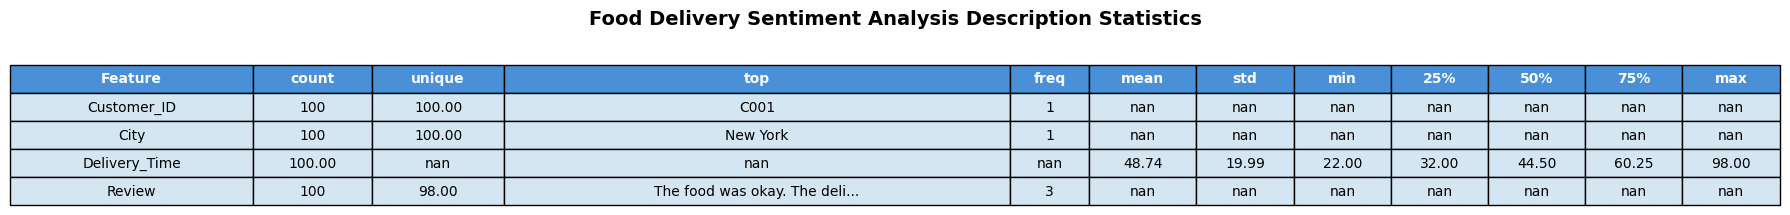

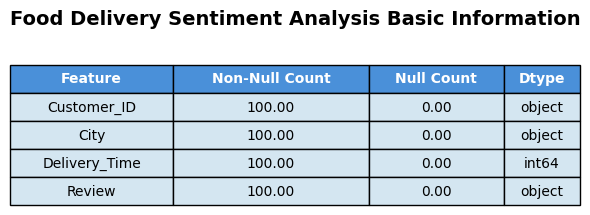

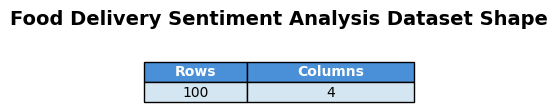


No data to display: Food Delivery Sentiment Analysis Missing Categorical (String) Data

No data to display: Food Delivery Sentiment Analysis Missing Numeric Data



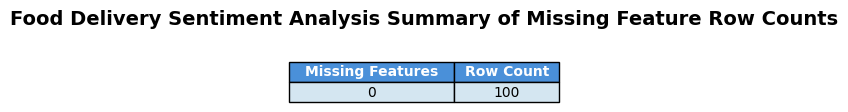

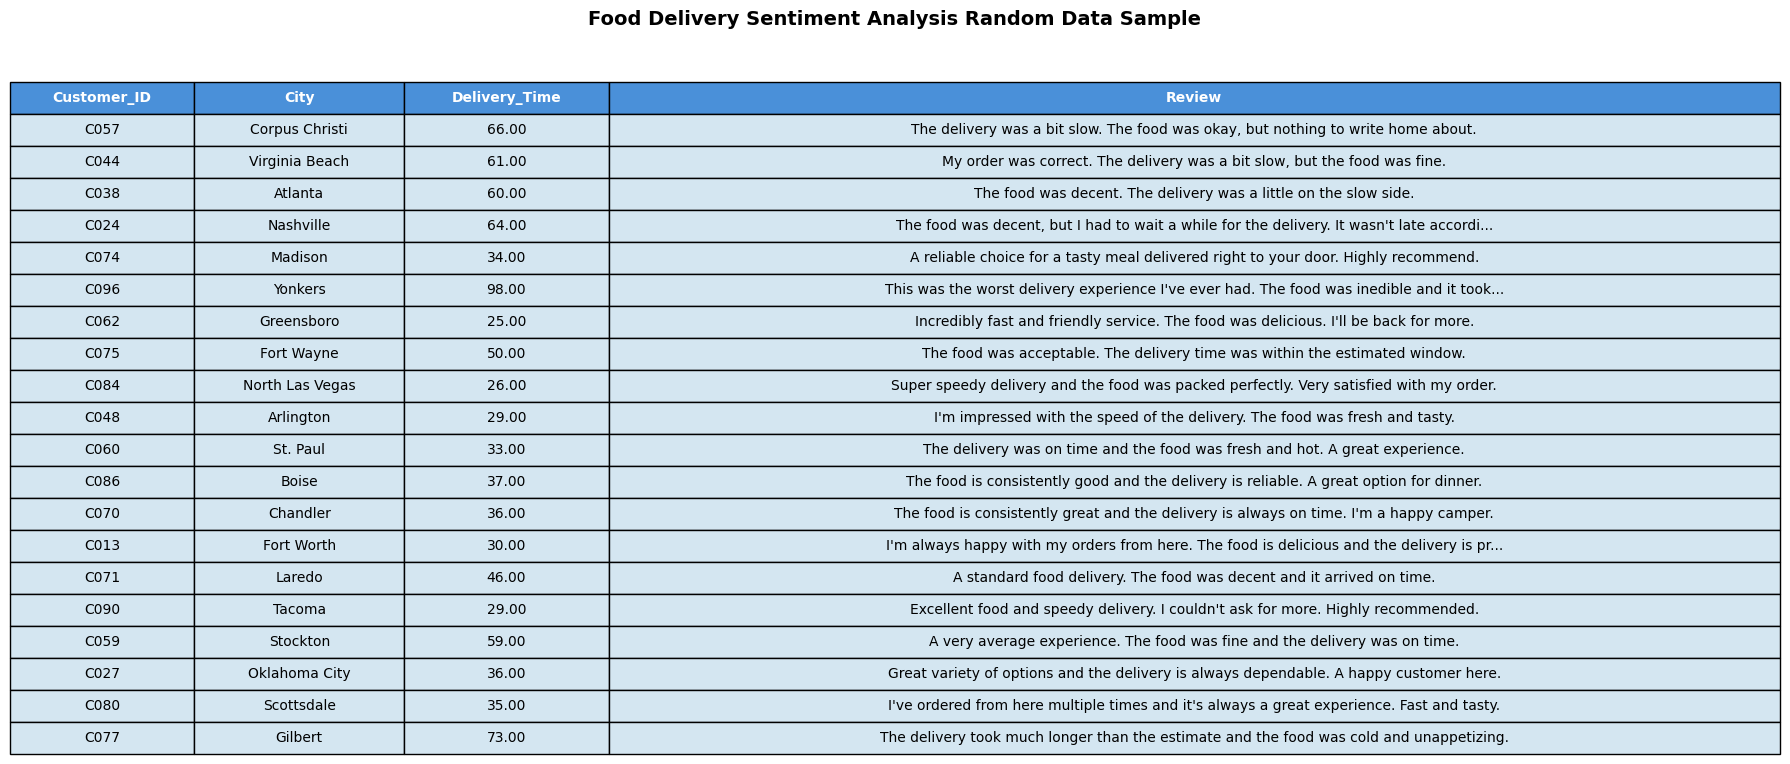

In [55]:
PrintDataFrameStatus(df_full_dataset)

## 1. Ground Truth Data Set

In [ ]:
# Set file paths based on environment
groundtruth_dataset_path = 'Ground Truth Results - Food Delivery Sentiment Analysis.csv'

# Load the training and testing datasets
df_groundtruth = pd.read_csv(groundtruth_dataset_path)

data_set_name = 'Ground Truth'
DisplaySampleDataInTable(df_groundtruth, max_cell_length=90)

data_set_name = 'Food Delivery Sentiment Analysis'

#### **Potential Data Issues from Imported Data** ####
    The following columns (features) have missing data:
        There are no features with missing/null/<nan> data.
    
##### **Validate Data Features** #####
    Test each categorical feature to ensure it's context and validity

In [56]:
# print('==========================================================================')

# categorical_features=['REASON','JOB']

# for i, feature_name in enumerate(categorical_features):
#     ExamineCategoricalFeatures(df_loandefaults, feature_name)

# print()
# print()    

#### <b>Data Type Conversions</b> ####

In [57]:
# # Data Type Conversions

# # int8 Conversions
# columns = ['BAD','YOJ','DEROG','DELINQ','NINQ','CLNO']
# df_loandefaults[columns] = df_loandefaults[columns].round(0).astype('Int8')

#### <b>Initial Histograms of Raw Numeric Features</b> ####

In [58]:
# #
# DisplayNumericFeatureHistgorams(df_loandefaults, target_label=feature_label, plot_title='Loan Default Predictions Dataset Features') 
# print()
# print()

#### <b>Initial BoxPlots of Raw Numeric Features</b> ####
Help check for outliers

In [59]:
# PlotBoxPlotsToViewDistributions(df_loandefaults, target_label=feature_label, plot_title='Training Dataset')
# print()
# print()

# PlotBoxPlotsToViewDistributions(df_loandefaults, plot_title='Testing Dataset')
print()
print()

#### <b>Initial BarCount Plot of Raw Numeric Features</b> ####

In [60]:
# countable_features = ['BAD', 'YOJ', 'DEROG', 'DELINQ', ]
# DisplayBarCountPlotsOfCategoricFeatures(df_loandefaults, countable_features, plot_title='Loan Default Predictions' )
print()
print() 

## 2. Feature engineering

In [61]:
# Your code here...

## 3. Model building

In [62]:
# Your code here...

## 4. Model evaluation

In [63]:
# Your code here...